In [1]:
import matplotlib.pyplot as plt
from src.utils.plot_utils import *
from src.utils.sim_utils import *
import yaml
import numpy as np
import jax.numpy as jnp
import sparse
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from omegaconf import DictConfig, OmegaConf
from pathlib import Path, PosixPath
import h5py

Using diffeqsolve-based neural simulation (original)


In [2]:
# # PLOT defaults
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["axes.spines.right"] = "False"
plt.rcParams["axes.spines.top"] = "False"
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["figure.figsize"] = (2,2)
plt.rcParams['axes.linewidth'] = 0.25
plt.rcParams["xtick.major.size"] = 1.7
plt.rcParams["xtick.minor.size"] = 1.0
plt.rcParams["ytick.major.size"] = 1.7
plt.rcParams["xtick.major.width"] = 0.25
plt.rcParams["xtick.minor.width"] = 0.18
plt.rcParams["ytick.major.width"] = 0.25
plt.rcParams["figure.dpi"] = 200

plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["xtick.major.pad"] = 1.5
plt.rcParams["ytick.major.pad"] = 1.5

SMALL_SIZE = 6
LABEL_SIZE = 7
AXLABEL_SIZE = 8
TITLE_SIZE = 10

plt.rcParams["font.family"] = "Arial" # "Arial"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXLABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LABEL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

moduleColors = get_module_colors()

dnColor = "#51bbad"
excColor = "#d84a2e"
inhColor = "#026b85"
mnColor = "#267655"

lightDnColor = "#a7dcd5ff"
lightExcColor = "#ff9985"

dataPath = "/data/users/smpuglie/Pugliese_2025/"

## FANC 1024x DNg100 activation, minimal circuit only

In [8]:
simType = "DNg100_Stim_FANC"
simPath = simType+"/walle-smpuglie/run_id=coreCpg"
folder = dataPath + simPath
Rs = sparse.load_npz(folder+f"/ckpt/{simType}_Rs.npz").todense()
params = DictConfig(load_from_yaml(folder+"/.hydra/config.yaml"))

dataset = 0
Rs = Rs[dataset]
nSims = Rs.shape[0]
Rs.shape

(1024, 803, 2001)

In [4]:
wTable = pd.read_csv("../"+params.experiment["dfPath"].split("Pugliese_2025")[1])
mnData = sort_motor_modules(wTable.loc[wTable["motor module"].notna()])
nMnsActive = pd.Series(index=np.arange(nSims))
nMnsActiveTinyThreshold = pd.Series(index=np.arange(nSims))
simScore = pd.Series(index=np.arange(nSims))

for i in range(nSims):
    # active neurons
    R = Rs[i]
    
    activeMnsMask = (np.max(R,1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    nMnsActive.loc[i] = np.sum(activeMnsMask)
    activeMnsMaskPastTransient = (np.max(R[:,250:],1)>0.01) & (jnp.isin(jnp.arange(R.shape[0]), mnData.index.to_numpy()))
    score, _ = compute_oscillation_score(R[...,250:],activeMnsMaskPastTransient)
    nMnsActiveTinyThreshold.loc[i] = np.sum(activeMnsMaskPastTransient)
    simScore.loc[i] = score

figFolder = "../figures/"
figFolder += "-".join(str.split(simPath,"/"))

/home/smpuglie/Pugliese_2025/src/utils/plot_utils.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neuronData[colName] = pd.Categorical(neuronData[colName],categories=["coxa swing", "coxa stance", "femur/tr extend", "femur/tr flex",


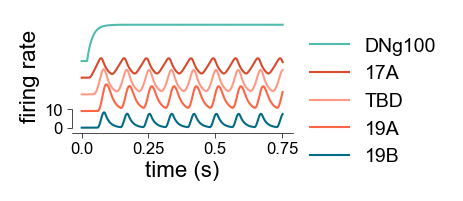

85
0.9998072385787964


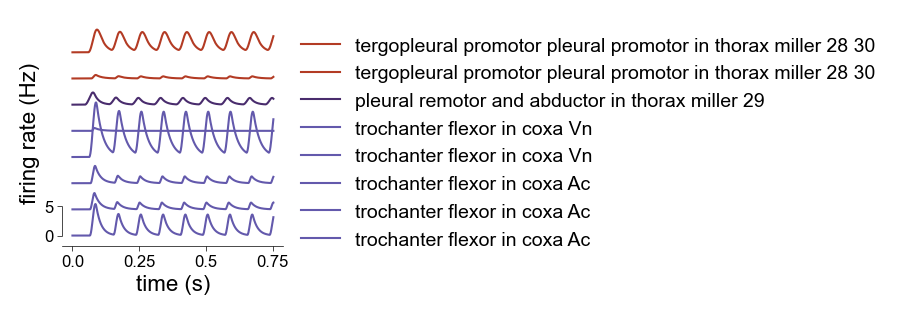

In [21]:
coreCpgData = wTable.loc[params.experiment.keepOnly]

idx = np.random.randint(1000) 
spacer = 9
width = 3

R = Rs[idx]

plt.figure()
ax = plot_R_traces_stacked_2(R[:,:750],coreCpgData,activeOnly=False,space=spacer,fanc=True,colors=[dnColor,excColor,lightExcColor,"#ff6444ff",inhColor])
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,10,"k",linewidth=0.25)
plt.yticks([0,10])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.tick_params(labelsize=6)
ax.grid(False)
# plt.ylabel("firing rate (Hz)",fontsize=8)
plt.xlabel("time (s)")
fig = plt.gcf()
fig.set_figwidth(1.426)
fig.set_figheight(1.226*3/5)



plt.show()

spacer = 4.5
plt.figure()
print(idx)
ax = plot_R_traces_stacked_by_module(R[:,:750],mnData,activeOnly=True,space=spacer,fanc=True)# ,colorMapper=colorMapper)
add_tAxis(ax,0.75,3.0001)
xlimits = ax.get_xlim()
plt.vlines(xlimits[0],0,5,"k",linewidth=0.25)
plt.yticks([0,5])
plt.xlim(xlimits)
ax.spines[["left","top","right"]].set_visible(False)
ax.tick_params(labelsize=6)
ax.grid(False)
# plt.ylabel("firing rate (Hz)",fontsize=8)
plt.xlabel("time (s)")
fig = plt.gcf()

fig.set_figwidth(1.426)
fig.set_figheight(1.226*6/5)

print(simScore[idx])



plt.show()

<Axes: ylabel='firing rate'>

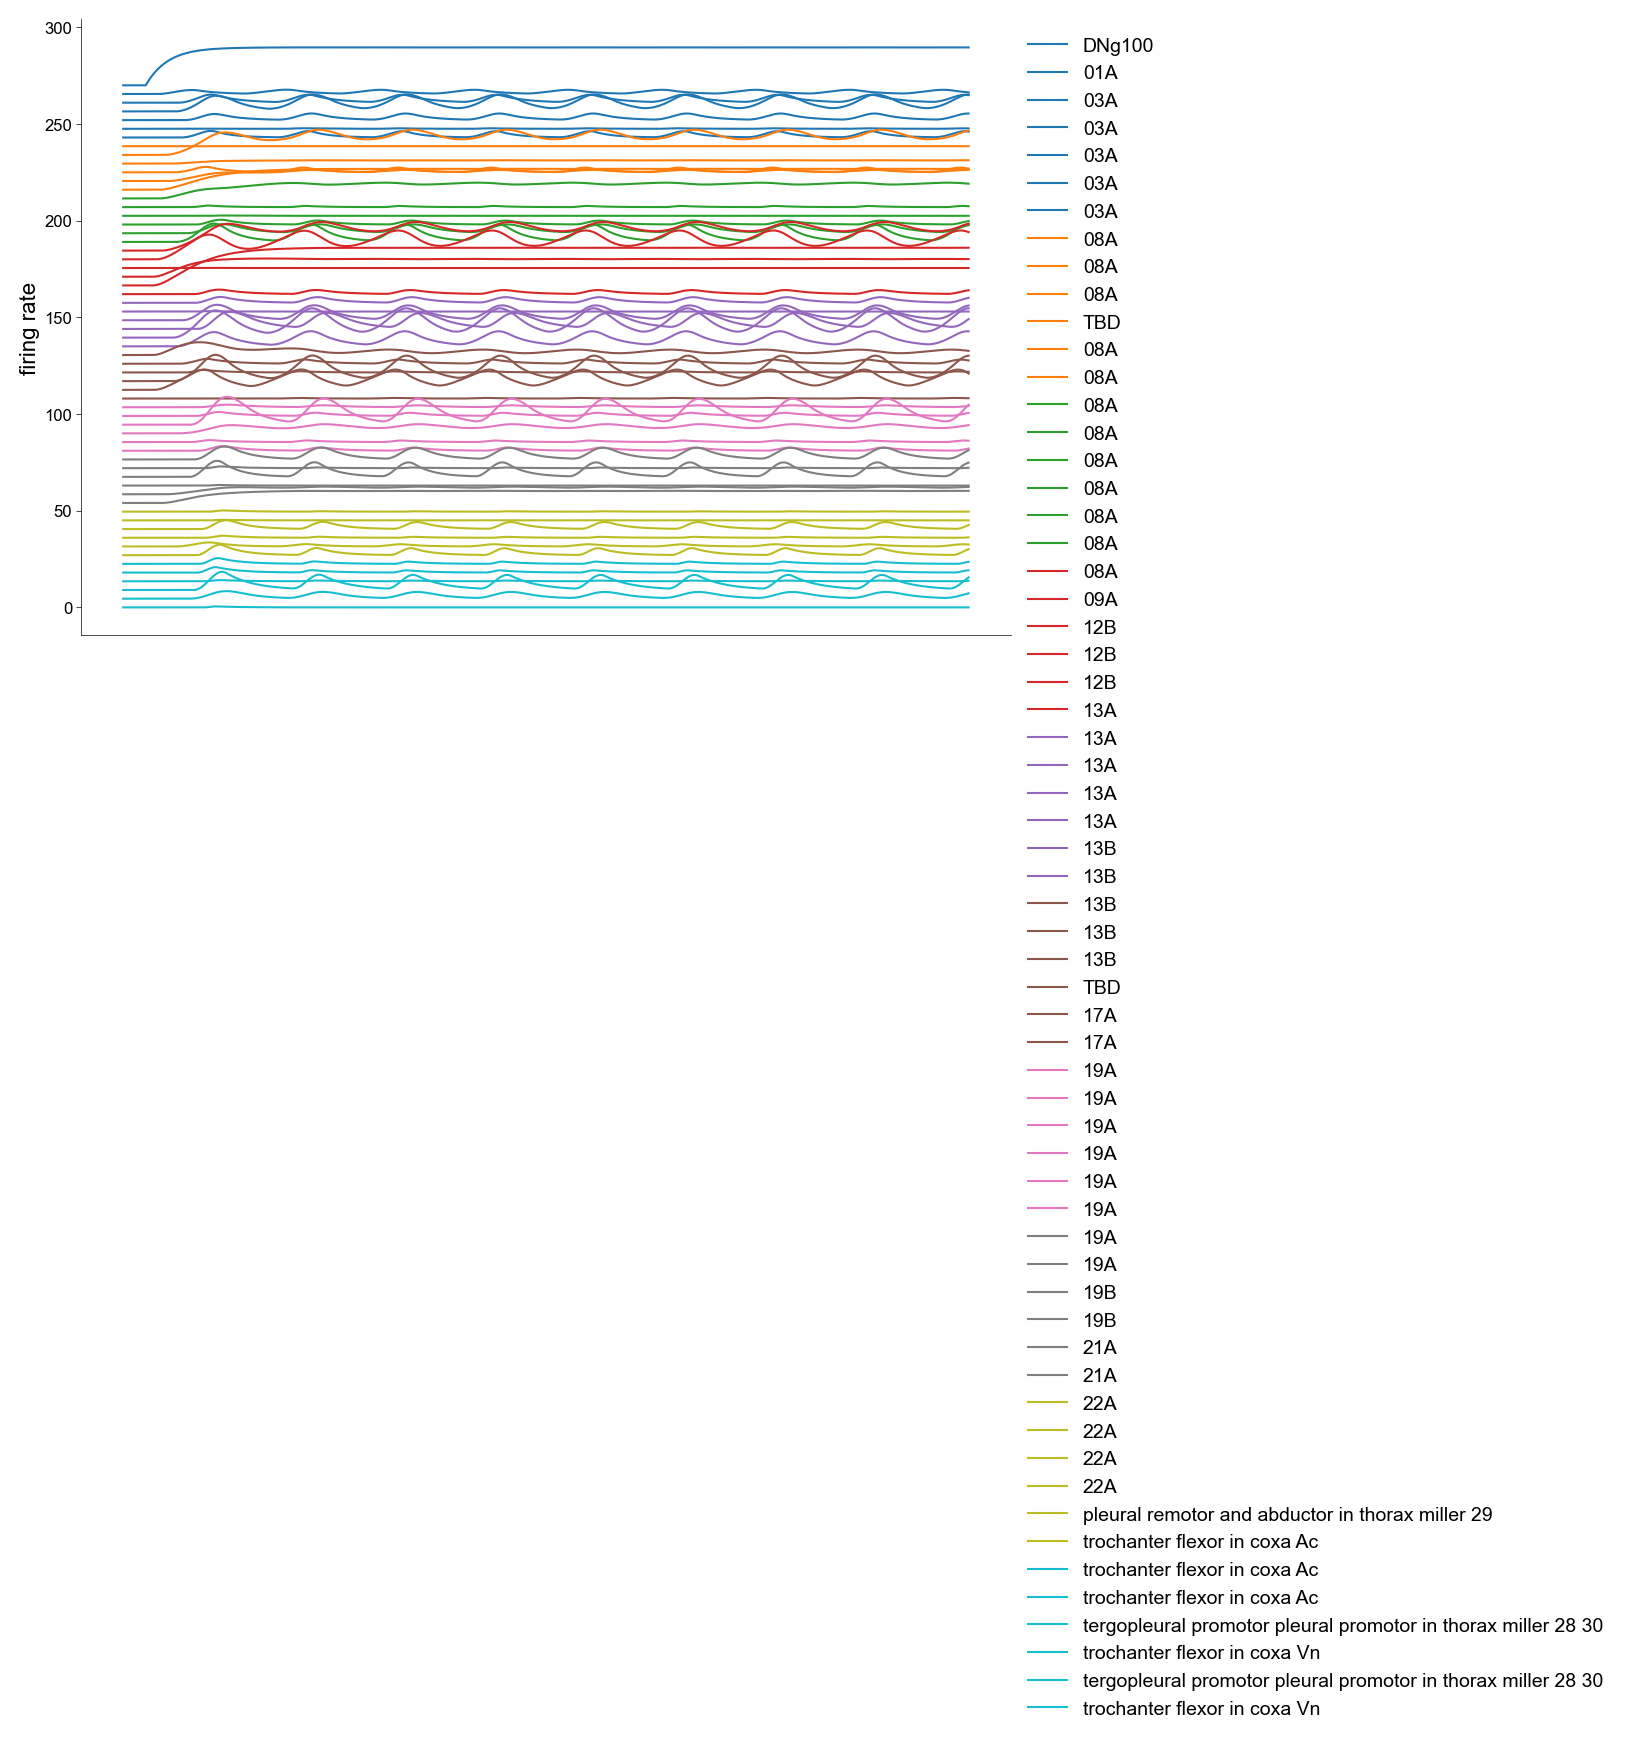

In [22]:
plot_R_traces_stacked_2(R[:,:750],wTable,activeOnly=True,space=spacer,fanc=True)

4 works fine here too actually

In [7]:
params.experiment.keepOnly

[]

# 😭